In [1]:
import torch
import wandb
from hydra import compose, initialize

from dviforbml.evaluation.visualization.visualize_dvinp import visualize_dvinp
from dviforbml.evaluation.visualization.visualize_task import visualize_task
from dviforbml.utils.helper import download_run, get_name_dvinp
from dviforbml.utils.load_dvinp import load_dvinp

In [2]:
import warnings

warnings.filterwarnings("ignore")

In [3]:
try:
    import torch_directml

    device = torch_directml.device()
except ImportError:
    device = torch.device("cpu")

In [4]:
# project = "cluster-dvinp-linesine"
# name = "16-None-mean-cos-dis-True-cntxt"  # "16-1-bca-free-dis-True-False-context-1.0-0"
# dir = download_run(project, name)

dir = "../models/dvinp"

In [5]:
with initialize(version_base=None, config_path=dir):
    cfg = compose(config_name="cfg")

    model, trainer, test_loader, _ = load_dvinp(
        cfg=cfg, device=device, dir=dir, load_decoder_only=False, train_decoder=True
    )

# torch.save(model.decoder.state_dict(), f"{dir}/decoder.pth")


Generating tasks: 100%|██████████| 4096/4096 [00:00<00:00, 304063.10it/s]
Dropped Escape call with ulEscapeCode : 0x03007703


model not found at ../models/dvinp/model.pth
optim not found at ../models/dvinp/optim.pth


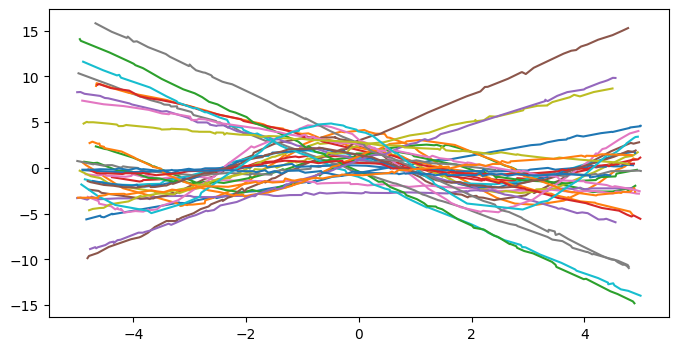

In [6]:
visualize_task(test_loader)

In [7]:
trainer.wandb_logging = True
if trainer.wandb_logging:
    wandb.init(project="test", name=get_name_dvinp(cfg))

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


wandb: Currently logged in as: max-burzer (max-burzer-karlsruhe-institute-of-technology) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [8]:
train = True

if train:
    # trainer.optimizer.param_groups[0]["lr"] = 0.1 * cfg.training.learning_rate
    # print(trainer.optimizer.param_groups[0]["lr"])

    num_epochs = 200
    losses = trainer.train(
        num_epochs=num_epochs,
        max_clip_norm=cfg.training.max_clip_norm,
        alpha=cfg.training.alpha,
        validate=True,
    )

    # torch.save(dvinp.state_dict(), f"{dir}/dvinp.pth")

 38%|███▊      | 12/32 [00:05<00:08,  2.31it/s, epoch=56, loss=88.1, lmpl=-154, mse=424]


ValueError: Expected parameter scale (Tensor of shape (128, 32, 2)) of distribution Normal(loc: torch.Size([128, 32, 2]), scale: torch.Size([128, 32, 2])) to satisfy the constraint GreaterThan(lower_bound=0.0), but found invalid values:
tensor([[[0.3825, 0.0300],
         [0.3896, 0.0561],
         [0.3956, 0.0823],
         ...,
         [0.3793, 0.0241],
         [0.3825, 0.0300],
         [0.3806, 0.0259]],

        [[0.3773, 0.0142],
         [0.3760, 0.0190],
         [0.3780, 0.0146],
         ...,
         [0.3772, 0.0148],
         [0.3748, 0.0197],
         [0.3788, 0.0156]],

        [[0.3757, 0.0195],
         [0.3758, 0.0191],
         [0.3785, 0.0233],
         ...,
         [0.3686, 0.0134],
         [0.3769, 0.0208],
         [0.3767, 0.0208]],

        ...,

        [[0.3831, 0.0220],
         [0.3798, 0.0167],
         [0.3735, 0.0130],
         ...,
         [0.3776, 0.0152],
         [0.3770, 0.0152],
         [0.3758, 0.0143]],

        [[0.3834, 0.0311],
         [0.3855, 0.0406],
         [0.3829, 0.0291],
         ...,
         [0.3817, 0.0251],
         [0.3833, 0.0307],
         [0.3822, 0.0283]],

        [[0.3568, 0.0054],
         [0.3547, 0.0053],
         [0.3550, 0.0053],
         ...,
         [0.3556, 0.0051],
         [0.3573, 0.0056],
         [0.3546, 0.0065]]], device='privateuseone:0', grad_fn=<SqrtBackward0>)

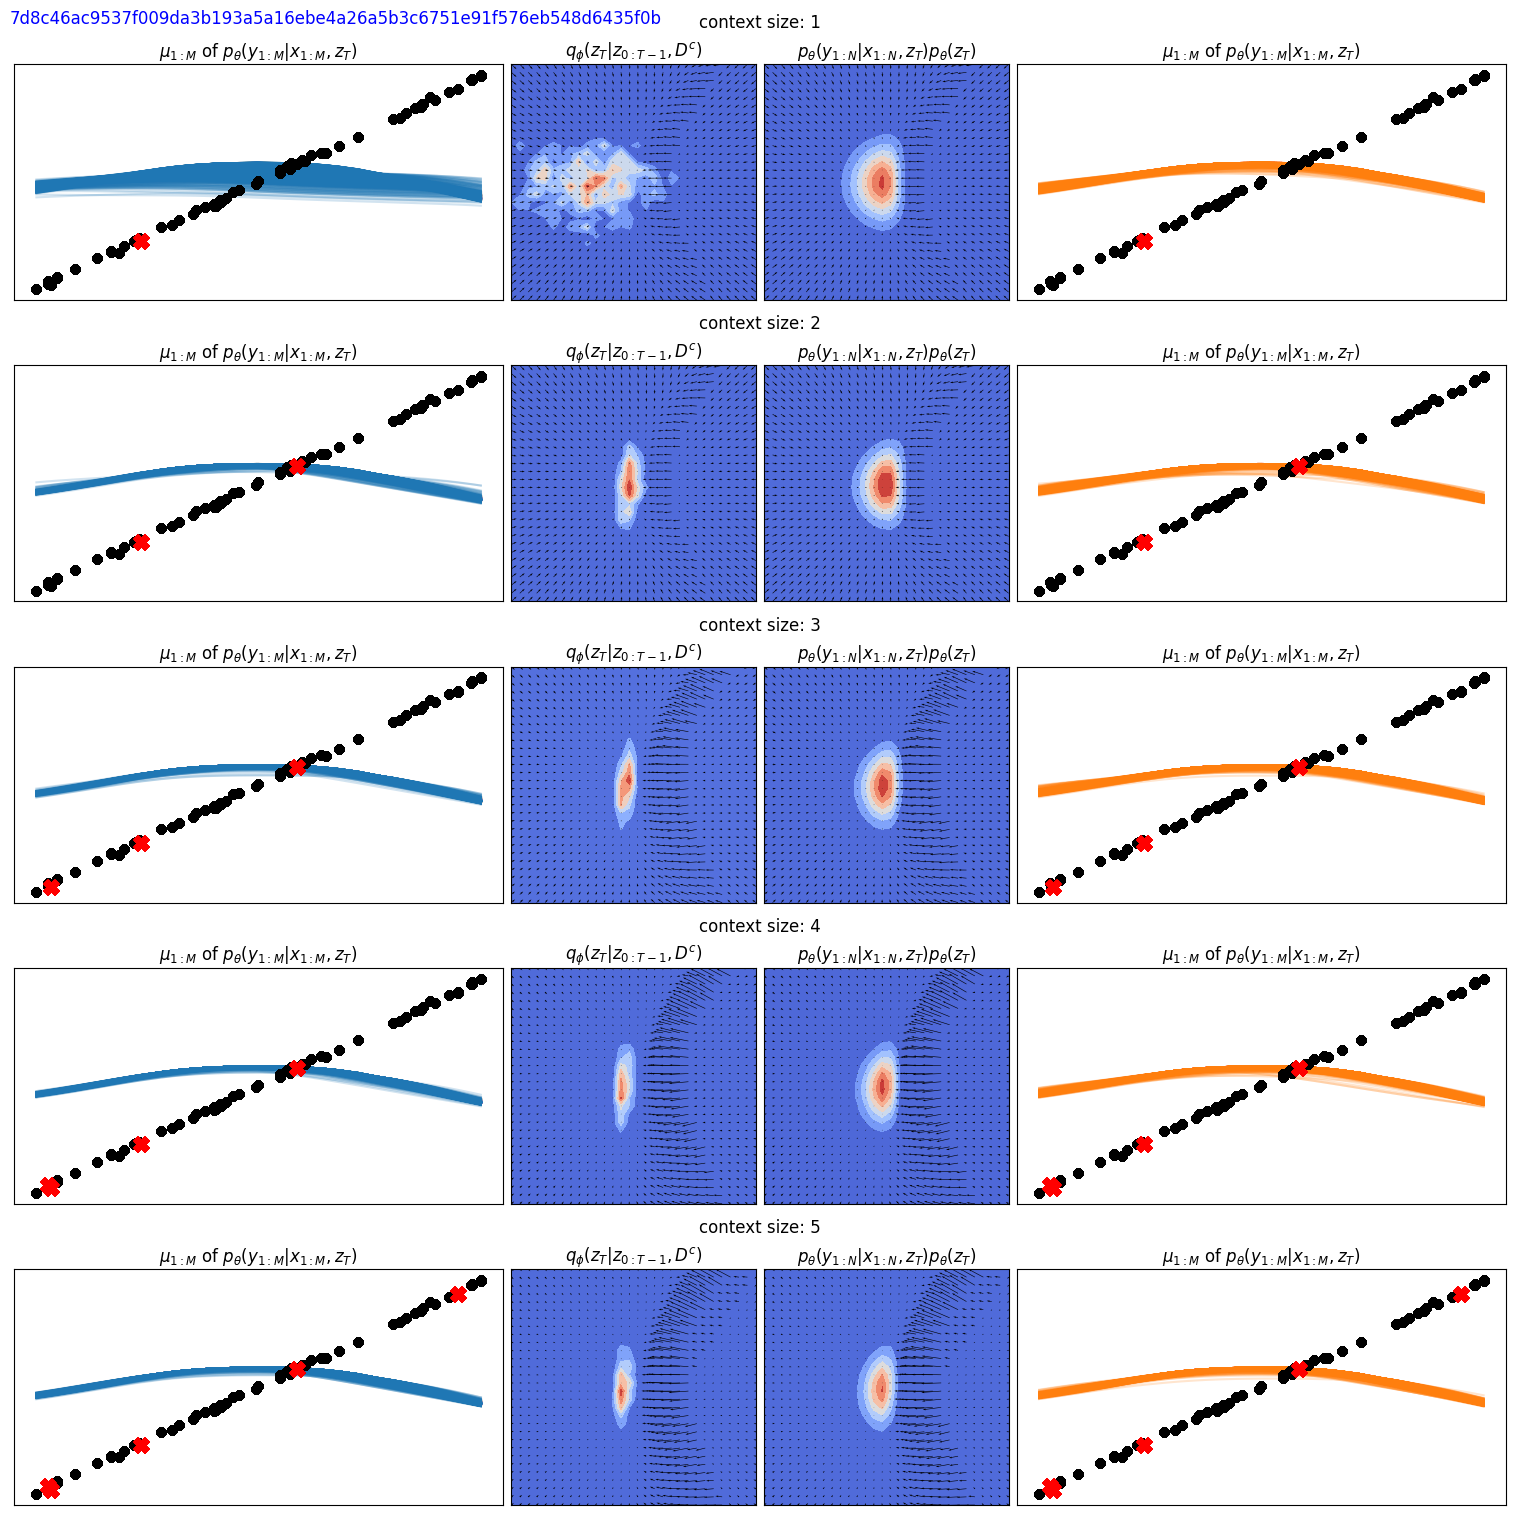

In [9]:
max_context_size = 5
num_samples = 900  # num_cells will be root

ranges = [(-5, 5), (-5, 5)]

targets, samples = visualize_dvinp(
    device=device,
    dvinp=model,
    dataloader=test_loader,
    num_samples=num_samples,
    max_context_size=max_context_size,
    ranges=ranges,
)